### 임포트 및 디바이스 설정

In [46]:
# pytorch
import torch 
from torch import nn, optim 
from torchvision import datasets, transforms 
from torch.utils.data import Dataset, DataLoader, random_split 
from torch.optim.lr_scheduler import _LRScheduler

# matplotlib
import matplotlib.pyplot as plt

# etc
import os
import math
import random
from tqdm import tqdm  # 진행도 측정용
import onnx
import onnxruntime
import numpy as np

# GPU가 인식되면 GPU 사용, 아니면 CPU 사용
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
print(torch.__version__)

cuda
1.13.0


### 사용자 정의 함수

In [47]:
# 해당 로더에서 랜덤으로 n개의 이미지와 label을 출력한다
# dataset이 라벨링에 맞게 잘 정리됐는지 최소한의 판단 기준
def show_random_images(dataloaders, n=5):
    for phase, dataloader in dataloaders.items():
        print(f"\n--- {phase} Data ---")
        images, labels = next(iter(dataloader))  # Get a batch of data
        
        # Select random indices
        indices = random.sample(range(len(images)), n)
        selected_images = images[indices]
        selected_labels = labels[indices]
        
        # Plot images with their labels
        plt.figure(figsize=(15, n * 3))
        for i, (img, label) in enumerate(zip(selected_images, selected_labels)):
            plt.subplot(1, n, i + 1)
            plt.imshow(img.permute(1, 2, 0).numpy())  # Convert to HWC(Height*Width*Channels) for Matplotlib
            plt.title(f"Label: {label.item()}")
            plt.axis('off')
        plt.show()
        

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# pytorch의 모델을 onnx 포맷으로 저장
def SaveToONNX(model, onnx_save_path):
    model.eval()    # 평가 모드로 설정
    batch_size = 1  # 임의의 수
    input_names = ['input']
    output_names = ['output']

    # 모델을 미리 학습된 가중치로 초기화합니다
    map_location = lambda storage, loc: storage
    if torch.cuda.is_available():
        map_location = None

    x = torch.randn(batch_size, 3, 224, 224, requires_grad=True).to(DEVICE) # Model Input Shape
    torch_out = model(x) # For Performance Test

    # 모델 변환
    torch.onnx.export(model,                     # 실행될 모델
                    x,                           # 모델 입력값 (튜플 또는 여러 입력값들도 가능)
                    onnx_save_path,              # 모델 저장 경로 (파일 또는 파일과 유사한 객체 모두 가능)
                    export_params=True,          # 모델 파일 안에 학습된 모델 가중치를 저장할지의 여부
                    opset_version=10,            # 모델을 변환할 때 사용할 ONNX 버전
                    do_constant_folding=True,    # 최적화시 상수폴딩을 사용할지의 여부
                    input_names = input_names,   # 모델의 입력값을 가리키는 이름
                    output_names = output_names  # 모델의 출력값을 가리키는 이름
    )

    onnx_model = onnx.load(onnx_save_path)
    onnx.checker.check_model(onnx_model) # 모델의 구조를 확인하고 모델이 유효한 스키마(valid schema)를 가지고 있는지를 체크

    ort_session = onnxruntime.InferenceSession(onnx_save_path, providers=["CPUExecutionProvider"])

    # ONNX 런타임에서 계산된 결과값
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
    ort_outs = ort_session.run(None, ort_inputs)

    # (참고) numpy.testing.assert_allclose(actual, desired, rtol=1e-07, atol = 0, equal_nan = True, err_msg='', verbose=True)
    # actual과 desired에 비교하고자 하는 값을 넣고, actual값과 desired값이 atol+rtol * abs(desired) 값의 범위를 넘어가면 에러 메세지를 일으킴.

    # ONNX 런타임과 PyTorch에서 연산된 결과값 비교
    np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
    print("Exported model has been tested with ONNXRuntime, and the result looks good!")




### 모델 클래스
#### 현 예제에서는 ResNet을 사용

In [48]:
class BasicBlock(nn.Module):
    # Basic의 경우 64 채널 2번이라 1배. expansion=1
    expansion = 1
    def __init__(self, in_channels, inner_channels, stride = 1, projection = None):
        super().__init__()

        self.residual = nn.Sequential(nn.Conv2d(in_channels, inner_channels, 3, stride=stride, padding=1, bias=False),
                                      nn.BatchNorm2d(inner_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(inner_channels, inner_channels * self.expansion, 3, padding=1, bias=False),
                                      nn.BatchNorm2d(inner_channels))
        self.projection = projection
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.residual(x)

        if self.projection is not None:
            shortcut = self.projection(x) # 점선 연결
        else:
            shortcut = x # 실선 연결

        out = self.relu(residual + shortcut)
        return out

class Bottleneck(nn.Module):
    # expansion은 Bottleneck의 경우, 64->64->64*4 이런식으로 진행됨 
    # 따라서 마지막에 4배 해줘야 하므로 expansion=4.
    expansion = 4
    def __init__(self, in_channels, inner_channels, stride = 1, projection = None):
        super().__init__()

        self.residual = nn.Sequential(nn.Conv2d(in_channels, inner_channels, 1, bias=False),
                                      nn.BatchNorm2d(inner_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(inner_channels, inner_channels, 3, stride=stride, padding=1, bias=False),
                                      nn.BatchNorm2d(inner_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(inner_channels, inner_channels * self.expansion, 1, bias=False),
                                      nn.BatchNorm2d(inner_channels * self.expansion))

        self.projection = projection
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.residual(x)

        if self.projection is not None:
            shortcut = self.projection(x)
        else:
            shortcut = x

        out = self.relu(residual + shortcut)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_block_list, num_classes = 1000, zero_init_residual = True):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True) # 추가로 메모리 할당하지 않아서 메모리 효율
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.stage1 = self.make_stage(block, 64, num_block_list[0], stride=1)
        self.stage2 = self.make_stage(block, 128, num_block_list[1], stride=2)
        self.stage3 = self.make_stage(block, 256, num_block_list[2], stride=2)
        self.stage4 = self.make_stage(block, 512, num_block_list[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

        # (Optional) zero_init_residual을 사용하면 각 블록의 마지막 BN에서 weight를 0으로 초기화함.
        # 이로 인해 0.2~0.3% 정도 성능 향상이 있었다고 함. => https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, block):
                    nn.init.constant_(m.residual[-1].weight, 0)

    def make_stage(self, block, inner_channels, num_blocks, stride = 1):
        if stride != 1 or self.in_channels != inner_channels * block.expansion:
            # stride = 1 이여도 채널 수가 다르면 (stage1의 첫번째 BottleNeck) projection 해야함 (이 때는 resoltion은 그대로, 채널 수만 늘어남)
            projection = nn.Sequential(
                nn.Conv2d(self.in_channels, inner_channels * block.expansion, 1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels * block.expansion)) # 점선 connection 임
        else:
            projection = None

        layers = []
        
        # 첫번째 블록만 따로 처리함. (projection 처리를 위해서)
        layers += [block(self.in_channels, inner_channels, stride, projection)] 
        self.in_channels = inner_channels * block.expansion
        for _ in range(1, num_blocks): # 첫번째 제외한 나머지 레이어 처리
            layers += [block(self.in_channels, inner_channels)]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

In [49]:
def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

# 여기서부터는 Bottleneck Block 사용
def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)

def resnet101(**kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)

def resnet152(**kwargs):
    return ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)

### 상수 값

In [50]:
BATCH_SIZE = 64 # batch size
LR = 1e-4 # learning rate
EPOCH = 200 # input num of epoch
num_classes = 2 # input num of classes
criterion = nn.CrossEntropyLoss() # for Loss
model_type = "resnet18" # select model
dataset = "Mask_12K" # using dataset
dataset_path = f"/mnt/e/Base_Dataset" # dataset path
save_model_path = f"/mnt/e/Results/{model_type}_{dataset}_EPOCH{EPOCH}_LR{LR}.pt" # model path to save
save_onnx_path = f"/mnt/e/Results/{model_type}_{dataset}_EPOCH{EPOCH}_LR{LR}.onnx" # onnx path to save

train_share = 0.8 # percentage of train dataset 
valid_share = 0.10 # percentage of val dataset
test_share = 0.10 # # percentage of test dataset

### 데이터 셋


--- Train Data ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

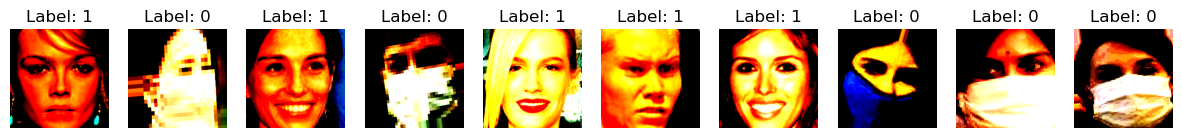


--- Valid Data ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

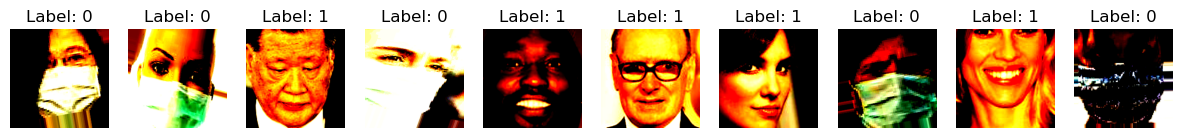


--- Test Data ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

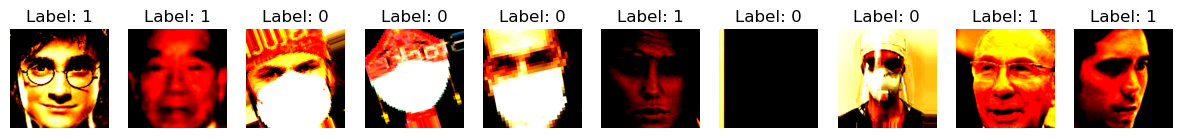

In [51]:
if dataset == "Mask_12K":
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5703, 0.4665, 0.4177), (0.2429, 0.2231, 0.2191)) # 본 데이터셋의 Mean, Std 값
        ]
    )
    
    dataset_path = f"/mnt/e/Mask_12K" # 데이터셋 경로    
    train_DS = datasets.ImageFolder(root=dataset_path, transform=transform) 
    # Default: train 80%, valid 10%, test 10%
    train_size = int(train_share * len(train_DS))
    valid_size = int(valid_share * len(train_DS))
    test_size = len(train_DS) - train_size - valid_size
    train_DS, val_DS, test_DS = random_split(train_DS, [train_size, valid_size, test_size])

    train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
    val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
    test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

    train_loader = DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False)
    
    # 적합하게 라벨링 되어있는지 랜덤으로 가져와서 테스트하는 용도
    dataloaders = { 'Train': train_DL, 'Valid':val_DL, 'Test': test_DL }
    show_random_images(dataloaders, n=10)

### 모델 설정

In [52]:
# 사용할 모델 선택
if model_type == "resnet18":
    model = resnet18(num_classes=num_classes).to(DEVICE)
elif model_type == "resnet34":
    model = resnet34(num_classes=num_classes).to(DEVICE)
elif model_type == "resnet50":
    model = resnet50(num_classes=num_classes).to(DEVICE)
elif model_type == "resnet101":
    model = resnet101(num_classes=num_classes).to(DEVICE)
elif model_type == "resnet152":
    model = resnet152(num_classes=num_classes).to(DEVICE)

print(model) # 모델 구성 확인
x_batch, _ = next(iter(train_DL)) 
print(model(x_batch.to(DEVICE)).shape)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage1): Sequential(
    (0): Bottleneck(
      (residual): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (projection): Sequentia

### 학습 및 검증

In [53]:
optimizer = optim.Adam(model.parameters(), lr=LR)

# ReduceLROnPlateau # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
# 후에 step에서 넣는 값(여기서는 val_loss)의 변화를 추적하여 LR 값을 조정하는 방식.
# 여기서는 val_loss가 연속적인 EPOCH 10(patience)회 동안 낮아지지(min) 않을 경우, 
# 새로운 LR 값을 LR * 0.1(factor)을 계산하여 생성한다. 단, 새로운 LR 값은 0(min_lr)을 넘어야한다.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=1e-4, threshold_mode='rel', min_lr=0, verbose=False)

train_losses = []
val_losses = []

best_val_loss = float('inf')
for ep in range(EPOCH):
    model.train() # (1) train - mode 전환
    train_loss = 0.0

    with tqdm(train_DL) as tepoch: # 진행도 체크용
        # Training Loop
        for x_batch, y_batch in train_DL: # (2) train - dataloader에서 이미지 및 라벨 한 묶음 가져오기
            tepoch.set_description(f"Epoch {ep+1} / {EPOCH}")
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            # (3) train - 순전파, 역전파 진행
            optimizer.zero_grad() # gradient 누적을 막기 위한 초기화
            y_hat = model(x_batch) # inference
            loss = criterion(y_hat, y_batch)
            loss.backward() # backpropagation
            optimizer.step() # weight update

            train_loss += loss.item()

        train_loss /= len(train_DL)
        train_losses.append(train_loss)
        
        # (4) val - mode 전환
        model.eval()
        val_loss = 0.0
        with torch.no_grad(): # gradient 자동 계산 X / val, test땐 gradient 계산이 필요없으니
            for x_batch, y_batch in val_DL: # (5) val - dataloader에서 이미지 및 라벨 한 묶음 가져오기
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                # (6) val - 순전파, 역전파 진행
                y_hat = model(x_batch) # inference 결과
                loss = criterion(y_hat, y_batch) # loss check
                val_loss += loss.item()
        
        val_loss /= len(val_DL)
        val_losses.append(val_loss)        
        print(f"Epoch [{ep+1}/{EPOCH}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # (7) Scheduler로 lr 값 업데이트
        if scheduler is not None:
            # 앞서 확인했듯이 ReduceLROnPlateau는 매 사이클마다 확인하는 메트릭이 필요함. 여기서는 val_loss의 값을 기준으로 한다.
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau): 
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # (8) 데이터 저장
        # 베스트 모델만 저장함. 여기서 베스트 모델은 val_loss 값이 낮은 것.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model, save_model_path)
            SaveToONNX(model, save_onnx_path)


Epoch 1 / 500:   0%|          | 0/148 [01:45<?, ?it/s]

Epoch [1/500], Train Loss: 0.4204, Val Loss: 0.3780


Epoch 1 / 500:   0%|          | 0/148 [01:57<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 2 / 500:   0%|          | 0/148 [01:13<?, ?it/s]

Epoch [2/500], Train Loss: 0.3596, Val Loss: 0.3674


Epoch 2 / 500:   0%|          | 0/148 [01:20<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 3 / 500:   0%|          | 0/148 [01:03<?, ?it/s]

Epoch [3/500], Train Loss: 0.3453, Val Loss: 0.3605


Epoch 3 / 500:   0%|          | 0/148 [01:11<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 4 / 500:   0%|          | 0/148 [01:10<?, ?it/s]


Epoch [4/500], Train Loss: 0.3364, Val Loss: 0.3681


Epoch 5 / 500:   0%|          | 0/148 [01:03<?, ?it/s]

Epoch [5/500], Train Loss: 0.3302, Val Loss: 0.3450


Epoch 5 / 500:   0%|          | 0/148 [01:11<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 6 / 500:   0%|          | 0/148 [01:04<?, ?it/s]

Epoch [6/500], Train Loss: 0.3288, Val Loss: 0.3313


Epoch 6 / 500:   0%|          | 0/148 [01:12<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 7 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [7/500], Train Loss: 0.3270, Val Loss: 0.3771


Epoch 8 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [8/500], Train Loss: 0.3235, Val Loss: 0.3340


Epoch 9 / 500:   0%|          | 0/148 [01:02<?, ?it/s]

Epoch [9/500], Train Loss: 0.3242, Val Loss: 0.3289


Epoch 9 / 500:   0%|          | 0/148 [01:10<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 10 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [10/500], Train Loss: 0.3225, Val Loss: 0.3300


Epoch 11 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [11/500], Train Loss: 0.3212, Val Loss: 0.3370


Epoch 12 / 500:   0%|          | 0/148 [01:03<?, ?it/s]

Epoch [12/500], Train Loss: 0.3208, Val Loss: 0.3247


Epoch 12 / 500:   0%|          | 0/148 [01:11<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 13 / 500:   0%|          | 0/148 [01:01<?, ?it/s]

Epoch [13/500], Train Loss: 0.3190, Val Loss: 0.3245


Epoch 13 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 14 / 500:   0%|          | 0/148 [01:02<?, ?it/s]

Epoch [14/500], Train Loss: 0.3187, Val Loss: 0.3233


Epoch 14 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 15 / 500:   0%|          | 0/148 [01:01<?, ?it/s]

Epoch [15/500], Train Loss: 0.3194, Val Loss: 0.3232


Epoch 15 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 16 / 500:   0%|          | 0/148 [01:10<?, ?it/s]


Epoch [16/500], Train Loss: 0.3178, Val Loss: 0.3245


Epoch 17 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [17/500], Train Loss: 0.3192, Val Loss: 0.3261


Epoch 18 / 500:   0%|          | 0/148 [01:02<?, ?it/s]

Epoch [18/500], Train Loss: 0.3185, Val Loss: 0.3228


Epoch 18 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 19 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [19/500], Train Loss: 0.3172, Val Loss: 0.3349


Epoch 20 / 500:   0%|          | 0/148 [01:01<?, ?it/s]

Epoch [20/500], Train Loss: 0.3158, Val Loss: 0.3190


Epoch 20 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 21 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [21/500], Train Loss: 0.3163, Val Loss: 0.3215


Epoch 22 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [22/500], Train Loss: 0.3162, Val Loss: 0.3217


Epoch 23 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [23/500], Train Loss: 0.3164, Val Loss: 0.3340


Epoch 24 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [24/500], Train Loss: 0.3171, Val Loss: 0.3216


Epoch 25 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [25/500], Train Loss: 0.3177, Val Loss: 0.3194


Epoch 26 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [26/500], Train Loss: 0.3155, Val Loss: 0.3413


Epoch 27 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [27/500], Train Loss: 0.3153, Val Loss: 0.3230


Epoch 28 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [28/500], Train Loss: 0.3168, Val Loss: 0.3224


Epoch 29 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [29/500], Train Loss: 0.3157, Val Loss: 0.3230


Epoch 30 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [30/500], Train Loss: 0.3156, Val Loss: 0.3213


Epoch 31 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [31/500], Train Loss: 0.3152, Val Loss: 0.3231


Epoch 32 / 500:   0%|          | 0/148 [01:02<?, ?it/s]

Epoch [32/500], Train Loss: 0.3141, Val Loss: 0.3180


Epoch 32 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 33 / 500:   0%|          | 0/148 [01:02<?, ?it/s]

Epoch [33/500], Train Loss: 0.3143, Val Loss: 0.3180


Epoch 33 / 500:   0%|          | 0/148 [01:10<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 34 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [34/500], Train Loss: 0.3137, Val Loss: 0.3190


Epoch 35 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [35/500], Train Loss: 0.3137, Val Loss: 0.3191


Epoch 36 / 500:   0%|          | 0/148 [01:01<?, ?it/s]

Epoch [36/500], Train Loss: 0.3136, Val Loss: 0.3177


Epoch 36 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 37 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [37/500], Train Loss: 0.3138, Val Loss: 0.3178


Epoch 38 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [38/500], Train Loss: 0.3136, Val Loss: 0.3182


Epoch 39 / 500:   0%|          | 0/148 [01:00<?, ?it/s]

Epoch [39/500], Train Loss: 0.3136, Val Loss: 0.3165


Epoch 39 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 40 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [40/500], Train Loss: 0.3135, Val Loss: 0.3185


Epoch 41 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [41/500], Train Loss: 0.3135, Val Loss: 0.3174


Epoch 42 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [42/500], Train Loss: 0.3136, Val Loss: 0.3170


Epoch 43 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [43/500], Train Loss: 0.3135, Val Loss: 0.3170


Epoch 44 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [44/500], Train Loss: 0.3135, Val Loss: 0.3171


Epoch 45 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [45/500], Train Loss: 0.3135, Val Loss: 0.3175


Epoch 46 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [46/500], Train Loss: 0.3133, Val Loss: 0.3183


Epoch 47 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [47/500], Train Loss: 0.3134, Val Loss: 0.3181


Epoch 48 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [48/500], Train Loss: 0.3135, Val Loss: 0.3178


Epoch 49 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [49/500], Train Loss: 0.3134, Val Loss: 0.3173


Epoch 50 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [50/500], Train Loss: 0.3133, Val Loss: 0.3181


Epoch 51 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [51/500], Train Loss: 0.3133, Val Loss: 0.3182


Epoch 52 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [52/500], Train Loss: 0.3134, Val Loss: 0.3191


Epoch 53 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [53/500], Train Loss: 0.3134, Val Loss: 0.3188


Epoch 54 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [54/500], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 55 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [55/500], Train Loss: 0.3133, Val Loss: 0.3178


Epoch 56 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [56/500], Train Loss: 0.3136, Val Loss: 0.3182


Epoch 57 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [57/500], Train Loss: 0.3133, Val Loss: 0.3181


Epoch 58 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [58/500], Train Loss: 0.3133, Val Loss: 0.3186


Epoch 59 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [59/500], Train Loss: 0.3135, Val Loss: 0.3173


Epoch 60 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [60/500], Train Loss: 0.3133, Val Loss: 0.3184


Epoch 61 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [61/500], Train Loss: 0.3134, Val Loss: 0.3174


Epoch 62 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [62/500], Train Loss: 0.3133, Val Loss: 0.3180


Epoch 63 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [63/500], Train Loss: 0.3134, Val Loss: 0.3172


Epoch 64 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [64/500], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 65 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [65/500], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 66 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [66/500], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 67 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [67/500], Train Loss: 0.3134, Val Loss: 0.3176


Epoch 68 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [68/500], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 69 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [69/500], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 70 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [70/500], Train Loss: 0.3134, Val Loss: 0.3170


Epoch 71 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [71/500], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 72 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [72/500], Train Loss: 0.3133, Val Loss: 0.3177


Epoch 73 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [73/500], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 74 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [74/500], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 75 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [75/500], Train Loss: 0.3133, Val Loss: 0.3183


Epoch 76 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [76/500], Train Loss: 0.3134, Val Loss: 0.3169


Epoch 77 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [77/500], Train Loss: 0.3133, Val Loss: 0.3190


Epoch 78 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [78/500], Train Loss: 0.3134, Val Loss: 0.3187


Epoch 79 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [79/500], Train Loss: 0.3133, Val Loss: 0.3178


Epoch 80 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [80/500], Train Loss: 0.3133, Val Loss: 0.3183


Epoch 81 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [81/500], Train Loss: 0.3133, Val Loss: 0.3167


Epoch 82 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [82/500], Train Loss: 0.3133, Val Loss: 0.3185


Epoch 83 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [83/500], Train Loss: 0.3133, Val Loss: 0.3179


Epoch 84 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [84/500], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 85 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [85/500], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 86 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [86/500], Train Loss: 0.3133, Val Loss: 0.3180


Epoch 87 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [87/500], Train Loss: 0.3133, Val Loss: 0.3179


Epoch 88 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [88/500], Train Loss: 0.3133, Val Loss: 0.3168


Epoch 89 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [89/500], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 90 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [90/500], Train Loss: 0.3133, Val Loss: 0.3179


Epoch 91 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [91/500], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 92 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [92/500], Train Loss: 0.3134, Val Loss: 0.3179


Epoch 93 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [93/500], Train Loss: 0.3133, Val Loss: 0.3183


Epoch 94 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [94/500], Train Loss: 0.3133, Val Loss: 0.3181


Epoch 95 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [95/500], Train Loss: 0.3133, Val Loss: 0.3183


Epoch 96 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [96/500], Train Loss: 0.3133, Val Loss: 0.3166


Epoch 97 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [97/500], Train Loss: 0.3134, Val Loss: 0.3185


Epoch 98 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [98/500], Train Loss: 0.3133, Val Loss: 0.3184


Epoch 99 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [99/500], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 100 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [100/500], Train Loss: 0.3133, Val Loss: 0.3181


Epoch 101 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [101/500], Train Loss: 0.3134, Val Loss: 0.3175


Epoch 102 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [102/500], Train Loss: 0.3134, Val Loss: 0.3169


Epoch 103 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [103/500], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 104 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [104/500], Train Loss: 0.3133, Val Loss: 0.3191


Epoch 105 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [105/500], Train Loss: 0.3133, Val Loss: 0.3186


Epoch 106 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [106/500], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 107 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [107/500], Train Loss: 0.3133, Val Loss: 0.3179


Epoch 108 / 500:   0%|          | 0/148 [01:06<?, ?it/s]


Epoch [108/500], Train Loss: 0.3133, Val Loss: 0.3178


Epoch 109 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [109/500], Train Loss: 0.3133, Val Loss: 0.3188


Epoch 110 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [110/500], Train Loss: 0.3133, Val Loss: 0.3176


Epoch 111 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [111/500], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 112 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [112/500], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 113 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [113/500], Train Loss: 0.3133, Val Loss: 0.3184


Epoch 114 / 500:   0%|          | 0/148 [01:10<?, ?it/s]


Epoch [114/500], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 115 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [115/500], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 116 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [116/500], Train Loss: 0.3133, Val Loss: 0.3184


Epoch 117 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [117/500], Train Loss: 0.3133, Val Loss: 0.3179


Epoch 118 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [118/500], Train Loss: 0.3134, Val Loss: 0.3175


Epoch 119 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [119/500], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 120 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [120/500], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 121 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [121/500], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 122 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [122/500], Train Loss: 0.3133, Val Loss: 0.3192


Epoch 123 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [123/500], Train Loss: 0.3134, Val Loss: 0.3171


Epoch 124 / 500:   0%|          | 0/148 [01:07<?, ?it/s]


Epoch [124/500], Train Loss: 0.3133, Val Loss: 0.3181


Epoch 125 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [125/500], Train Loss: 0.3133, Val Loss: 0.3183


Epoch 126 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [126/500], Train Loss: 0.3133, Val Loss: 0.3186


Epoch 127 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [127/500], Train Loss: 0.3133, Val Loss: 0.3178


Epoch 128 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [128/500], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 129 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [129/500], Train Loss: 0.3134, Val Loss: 0.3178


Epoch 130 / 500:   0%|          | 0/148 [01:08<?, ?it/s]


Epoch [130/500], Train Loss: 0.3134, Val Loss: 0.3185


Epoch 131 / 500:   0%|          | 0/148 [01:09<?, ?it/s]


Epoch [131/500], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 132 / 500:   0%|          | 0/148 [01:01<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/e/Mask_12K/with_mask/Augmented_11_1899363.png'

### 학습 결과 그래프

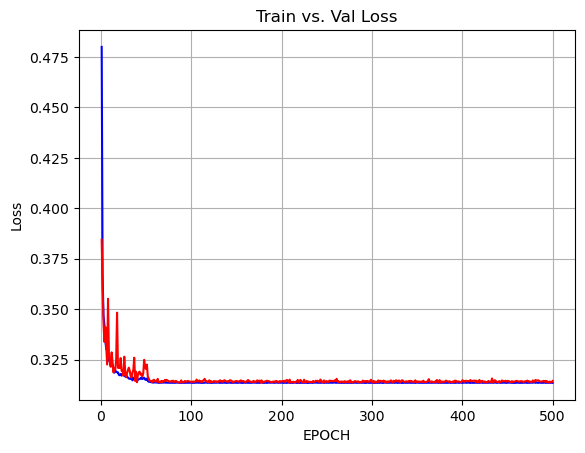

In [44]:
# EPOCH 별 val, train loss 체크
plt.plot(range(1, EPOCH+1), train_losses, 'b')
plt.plot(range(1, EPOCH+1), val_losses, 'r-')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('Train vs. Val Loss')
plt.grid()

### 테스트

In [45]:
model.eval()

test_loss = 0.0
correct = 0
total = 0

# Test Loop
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        y_hat = model(x_batch) # inference
        loss = criterion(y_hat, y_batch)
        test_loss += loss.item()
        
        _, predicted = torch.max(y_hat, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = 100.0 * correct / total
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Test Loss: 0.3179, Accuracy: 99.49%
